# Определение возраста покупателей

<b>Описание проекта</b>

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

<b>Цель проекта:</b>

Постройть модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

<b>Описание задачи:</b>

На основе предоставленных данных обучить модель которая определяет возраст покупателей.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model

## Исследовательский анализ данных

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
)

batch = next(train_gen_flow)

Found 7591 validated image filenames.


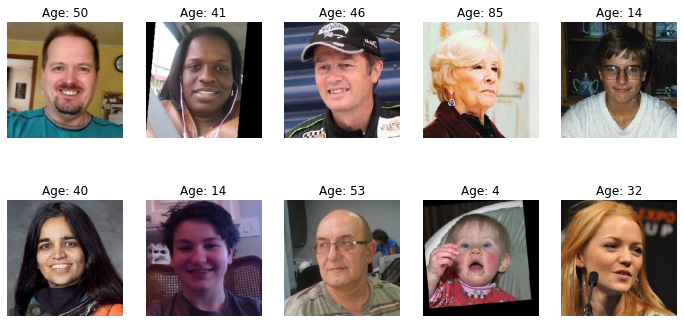

In [4]:
plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)  # >>> 2 rows, 5 columns
    plt.imshow(batch[0][i])
    plt.title(f"Age: {batch[1][i]:.0f}")
    plt.axis('off')

plt.show()

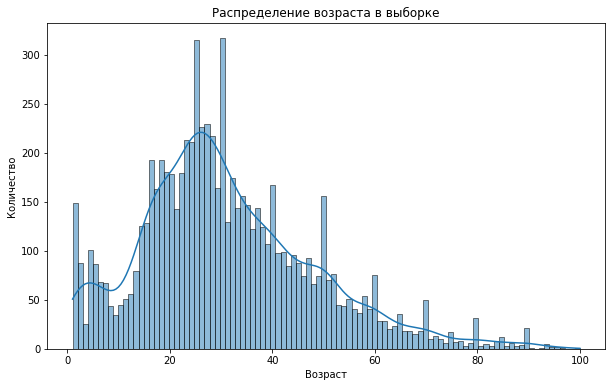

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

<b> Вывод по исследовательскому анализу данных</b>

- Проведенный исследовательский анализ данных показал что датасет состоит из 7591 записей. Файл состоит из фотографии и актуального возраста.

- Визуализация целевого признака (возраст) показала наличие пиков, то есть в некоторых группах (25 и 30 лет) много записей. фотографий людей старше 60 лет значительно меньше, однако это не критично, так как данная группа может покупать алкоголь, и в целом относиться в группе людей старшего возраста.

- Фотографии представлены в цветном формате (RGB), без искажений и в приемленом качестве, вертикальном положении.

## Обучение модели

In [7]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,       # нормализация
        horizontal_flip=True,    # случайное отражение
        validation_split=0.25    # выделяем 25% под валидацию
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',        # колонка с именем файла
        y_col='real_age',         # колонка с возрастом
        target_size=(224, 224),   # размер изображений
        batch_size=16,
        class_mode='raw',         # предсказываем число, а не класс
        subset='training',        # используем тренировочную часть
        seed=12345
    )

    return train_generator

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        rescale=1.0 / 255,      # нормализация
        validation_split=0.25   # используем те же 25% для валидации
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',       # колонка с именем изображения
        y_col='real_age',        # колонка с возрастом
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',        # предсказываем число
        subset='validation',     # используем валидационную часть
        seed=12345
    )

    return test_generator

def create_model(input_shape):

    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',       # используем веса ImageNet
        include_top=False         # убираем классификационную часть
    )

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(), # уменьшаем карту признаков
        Dense(12, activation='relu'),  # скрытый слой
        Dense(1)                       # финальный выход: предсказание возраста
    ])

    optimizer = Adam(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer,
        loss='mse',      # среднеквадратичная ошибка
        metrics=['mae']  # средняя абсолютная ошибка
    )

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    """
    Функция обучения модели на тренировочных данных с валидацией на тестовых данных.

    Параметры:
    - model: keras-модель
    - train_data: генератор тренировочных данных
    - test_data: генератор тестовых/валидационных данных
    - batch_size: размер батча (необязательно, генератор сам использует свой batch_size)
    - epochs: количество эпох
    - steps_per_epoch: количество шагов на эпоху (по умолчанию длина генератора)
    - validation_steps: количество шагов для валидации (по умолчанию длина генератора)
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    # Запуск обучения модели
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model

Train for 356 steps, validate for 119 steps

Epoch 1/10
356/356 - 48s - loss: 191.2814 - mae: 10.1202 - val_loss: 707.5854 - val_mae: 21.6246

Epoch 2/10
356/356 - 40s - loss: 80.0119 - mae: 6.7798 - val_loss: 164.2134 - val_mae: 9.6509

Epoch 3/10
356/356 - 40s - loss: 56.5537 - mae: 5.6873 - val_loss: 87.1586 - val_mae: 7.0859

Epoch 4/10
356/356 - 40s - loss: 40.9971 - mae: 4.9028 - val_loss: 87.9760 - val_mae: 7.1347

Epoch 5/10
356/356 - 41s - loss: 31.7236 - mae: 4.2700 - val_loss: 112.0159 - val_mae: 8.0302

Epoch 6/10
356/356 - 54s - loss: 23.7449 - mae: 3.7267 - val_loss: 69.4332 - val_mae: 6.1828

Epoch 7/10
356/356 - 55s - loss: 17.6528 - mae: 3.2356 - val_loss: 71.4558 - val_mae: 6.4816

Epoch 8/10
356/356 - 55s - loss: 17.2266 - mae: 3.1016 - val_loss: 69.5786 - val_mae: 6.3191

Epoch 9/10
356/356 - 57s - loss: 13.7524 - mae: 2.8116 - val_loss: 63.7334 - val_mae: 5.8599

Epoch 10/10
356/356 - 56s - loss: 12.5885 - mae: 2.6908 - val_loss: 64.2134 - val_mae: 6.0776

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 64.2134 - Test mae: 6.0776

## Анализ обученной модели

Модель обучалась 10 эпох на тренировочных данных и показала следующие показатели:

- MAE на тренировочной выборке: 2.69

- MAE на тестовой выборке: 6.08

Результаты показывают, что модель хорошо обучилась на тренировочных данных, но есть небольшое переобучение, так как ошибка на тестовой выборке заметно выше. Тем не менее, цель задачи (MAE ≤ 8) достигнута.

<b>Итоговый вывод</b>

- Разброс в точности определения возраста (MAE - 6.08) особенно когда покупателю 15 лет, а МО определяет его как 21 летнего, может привести к нежелательным последствиям. следовательно продавцам следует запрашивать документы у покупателей алкоголя если их возраст в диапазоне 20-26 лет, для подстраховки.

- При такой точности модель пригодна для аналитики покупательских сегментов и рекомендации товаров по возрастным категориям.

<div style="border:solid Chocolate 2px; padding: 40px">
    
**Общий вывод по проекту ревьювера**:
     Рустам, спасибо за проект! Ты приложил много усилий, чтобы довести его до конца, проделана огромная работа, и это видно невооруженным глазом, ты молодец! Но у меня осталось несколько дополнений, с которыми проект может стать еще лучше.
    
**Отмечу положительные моменты**:
    
    1. Все разложено по полочкам, проект хорошо оформлен, приятно смотреть.
              
    2. Наглядные визуализации.
    
    3. Логичные выводы.
    
**На что стоит обратить внимание**:
       
    1. Формирование вводной части 
    
    2. Доработка промежуточного и итогового выводов 


    
    
    
**Удачи и жду твой проект на повторное ревью!**
    
    

<div style="border:solid Chocolate 2px; padding: 40px">
    
**Общий вывод по проекту ревьювера V2**:
     Молодец, проект зачтен. Поздравляю тебя, увидимся в Практикуме.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы